<a href="https://colab.research.google.com/github/TatianaZ21/MachineLearning_TZ/blob/main/S2TC1_RandomForests_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import seaborn as sns

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1

#Definición de Parametros
valor_max_depth = 8 #Maxima profundidad
valor_num_pct = 10 #Numero de percentiles
valor_max_features = None #Maximas características
valor_min_reduccion = 0.001 #Reduccion minima

#Definición de funcion para calcular el RMSE del nodo o posible bifurcación
def RMSE(y):
    y_pred = np.mean(y)
    MSE = np.mean((y - y_pred)**2)
    RMSE = np.sqrt(MSE)
    return RMSE

#Definición de funcion que calcula la reduccion del RMSE para cada nodo
def Reduccion_RMSE (X_col, y, split):

    # Filtrar los datos en base al valor de división
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    # Calcular la cantidad de muestras en cada lado
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    # Calcular el RMSE del nodo
    RMSE_original = RMSE(y)
    RMSE_l = RMSE(y_l)
    RMSE_r = RMSE(y_r)

    # Calcular la reducción en el RMSE para cada posible bifurcación
    Valor_Reduccion_RMSE = RMSE_original - (n_l / (n_l + n_r) * RMSE_l + n_r / (n_l + n_r) * RMSE_r)

    return Valor_Reduccion_RMSE

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct = valor_num_pct ):

    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, Valor_Reduccion_RMSE

    # Para todas las varibles
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        # Para cada partición
        for split in splits:
            reduccion = Reduccion_RMSE(X.iloc[:, j], y, split)
            if reduccion > best_split[2]:
                best_split = [j, split, reduccion]

    return best_split

#Definición de funcion que agrupa las funciones y construye el arbol
def tree_grow(X, y, level=0, min_reduccion = valor_min_reduccion , max_depth = valor_max_depth, num_pct = valor_num_pct):

    # Si solo hay una observación
    if X.shape[0] == 1:
        # Creamos un nodo terminal con la predicción basada en la media de y
        tree = {'y_pred': y.iloc[0],
                'level': level,
                'split': -1,
                'n_samples': 1,
                'reduccion': 0}
        return tree

    # Si hay mas de una observación

    # Calcular la mejor división
    j, split, reduccion = best_split(X, y, num_pct = valor_num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()

    tree = {'y_pred': y_pred,
            'level': level,
            'split': -1,
            'n_samples': X.shape[0],
            'reduccion': reduccion}

    # Revisar el criterio de parada
    if reduccion < min_reduccion:
        return tree

    if max_depth is not None:
        if level >= max_depth:
            return tree

    # Continuar creando las particiones
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]

    tree['split'] = [j, split]
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_reduccion = valor_min_reduccion, max_depth = valor_max_depth, num_pct = valor_num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_reduccion = valor_min_reduccion, max_depth = valor_max_depth, num_pct = valor_num_pct)

    return tree

#Predicciones del arbol
def tree_predict(X, tree):

  #Inicializar un array para almacenar las predicciones
    predicted = np.zeros(X.shape[0])

    #Revisar si es el nodo final
    if tree['split'] == -1:
        # Si es el nodo final, la predicción será el valor de predicción en ese nodo
        predicted = tree['y_pred']
    else:
        #Obtener la característica y el punto de división en este nodo
        j, split = tree['split']
        #Filtrar las observaciones según la división
        filter_l = X.iloc[:, j] < split
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        # Realizar predicciones para los subárboles izquierdo y derecho
        if X_l.shape[0] > 0:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        if X_r.shape[0] > 0:
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted


## Ejecución del algoritmo
# Separación de variables predictoras (X) y variable de interés (y)
X.replace({False: 0, True: 1}, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Ejecución del arbol de decision manual
tree = tree_grow(X_train, y_train, level = 0, min_reduccion = valor_min_reduccion, max_depth = valor_max_depth, num_pct = valor_num_pct)
y_pred = tree_predict(X_test, tree)

#Validacion del modelo en test
MSE_Modelo_manual = np.mean((y_test - y_pred)**2)
MAE_Modelo_manual = np.mean(np.abs(y_test - y_pred))
RMSE_Modelo_manual = np.sqrt(MSE_Modelo_manual)
R2_Modelo_manual = 1 - MSE_Modelo_manual / np.var(y_test)

print("Métricas de desempeño arbol de decisión manual: \nMSE:", str(MSE_Modelo_manual),"\nMAE:", str(MAE_Modelo_manual),"\nRMSE:", str(RMSE_Modelo_manual),"\nR2:", str(R2_Modelo_manual))

Métricas de desempeño arbol de decisión manual: 
MSE: 2586051.788080778 
MAE: 1184.5874889694953 
RMSE: 1608.1205763501623 
R2: 0.8309344181239395


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error

Arbol_Regresor = DecisionTreeRegressor(min_impurity_decrease = valor_min_reduccion, max_depth = valor_max_depth, min_samples_split = valor_num_pct)
Arbol_Regresor.fit(X_train, y_train)
y_pred = Arbol_Regresor.predict(X_test)
MSE_Modelo = mean_squared_error(y_test, y_pred)
RMSE_Modelo = mean_squared_error(y_test, y_pred, squared=False)
MAE_Modelo = mean_absolute_error(y_test, y_pred)
R2_Modelo = r2_score(y_test, y_pred)

print("Métricas de desempeño arbol de decisión con libreria: \nMSE:", str(MSE_Modelo),"\nMAE:", str(MAE_Modelo),"\nRMSE:", str(RMSE_Modelo),"\nR2:", str(R2_Modelo))


Métricas de desempeño arbol de decisión con libreria: 
MSE: 2759822.1759726782 
MAE: 1205.325383003839 
RMSE: 1661.2712529784767 
R2: 0.8195740146404595


#### **Análisis desempeño del modelo árbol de decisión manual**
---


Como se puede observar, los valores de MSE, MAE y RMSE del árbol implementado manualmente son similares a los obtenidos con la implementación de la libreria. Es importante resaltar que con una profundidad de 8, el modelo muestra un buen desempeño en la predicción del precio del carro.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2

n_estimators = 10
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [ ]:
np.random.seed(123)
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeRegressor(max_depth=None, random_state=123)
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [ ]:
# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0


In [ ]:
# Desempeño de cada árbol
for i in range(n_estimators):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred_df.iloc[:,i], y_test)))

Árbol  0 tiene un error:  2141.613353645869
Árbol  1 tiene un error:  2136.3519863123465
Árbol  2 tiene un error:  2122.718759132052
Árbol  3 tiene un error:  2087.278992468617
Árbol  4 tiene un error:  2168.518742842026
Árbol  5 tiene un error:  2113.8811455834793
Árbol  6 tiene un error:  2127.933470769012
Árbol  7 tiene un error:  2184.414847251443
Árbol  8 tiene un error:  2138.1071697514985
Árbol  9 tiene un error:  2132.097520859104


In [ ]:
# Promedio
final_predictions = np.mean(y_pred_df, axis=1)

In [ ]:
final_predictions

257343    13767.4
326011     6243.1
242354    16694.3
266376    20865.3
396954    16468.1
           ...   
144298    14498.9
364521    16109.0
120072    21076.5
99878     12782.0
387162    11957.4
Length: 3464, dtype: object

In [ ]:
#métricas de desempeño
mse_bagm = mean_squared_error(y_test, final_predictions)
rmse_bagm = mean_squared_error(y_test, final_predictions)**0.5
r2_bagm = r2_score(y_test, final_predictions)
print(f"Métricas de desempeño Bagging: \nMSE = {mse_bagm:.2f} \nRMSE = {rmse_bagm:.2f} \nR2= {r2_bagm:.2f}")

Métricas de desempeño Bagging: 
MSE = 3227180.82 
RMSE = 1796.44 
R2= 0.79


#### **Análisis desempeño del modelo Bagging manual**
---
1. **Error cuadrático medio (MSE):** el MSE indica que el error promedio entre los valores reales y los valores predichos empleando este modelo es de 3227180,82. Entre menor sea este valor, mejor es el ajuste del modelo a los datos observados.
2. **Raíz del error cuadrático medio (RMSE):**  el RMSE es de 1796,44, lo que significa que hay una diferencia promedio de 1796,44 entre el valor real y el valor predicho por el modelo. Para este caso, esta cifra representa la diferencia promedio entre el precio predicho y el precio real observado en los datos de prueba. Este indice permite medir la precisión del modelo con una escala de unidades de los datos reales.
3.  **Coeficiente de determinación (R2):** con este modelo el R2 es de 0,79, lo cual indica que el modelo logra explicar aproximandamente el 79 % de la variabilidad observada en los datos, por lo tanto este modelo tiene un rendimiento moderadamente alto.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3
# Selección de variables predictoras
feature_cols = X.columns
feature_cols

## Entrendamiento del modelo
bagged_trees = BaggingRegressor(estimator=DecisionTreeRegressor(max_features=int(np.log(len(feature_cols)))),n_estimators=10, random_state=1)
modelo = bagged_trees.fit(X_train, y_train)

## Predicciones
y_pred = bagged_trees.predict(X_test)

#métricas de desempeño
mse_bag = mean_squared_error(y_test, y_pred)
rmse_bag= mean_squared_error(y_test, y_pred)**0.5
r2_bag = r2_score(y_test, y_pred)
print(f"Métricas de desempeño Bagging: \nMSE = {mse_bag:.2f} \nRMSE = {rmse_bag:.2f} \nR2= {r2_bag:.2f}")

Métricas de desempeño Bagging: 
MSE = 3328042.72 
RMSE = 1824.29 
R2= 0.78


#### **Análisis desempeño del modelo Bagging con librería**
---
1. **Error cuadrático medio (MSE):** el MSE indica que el error promedio entre los valores reales y los valores predichos empleando este modelo es de 3328042.72.
2. **Raíz del error cuadrático medio (RMSE):**  el RMSE es de 1824.29, lo que significa que hay una diferencia promedio de 1824.29 entre el valor real y el valor predicho por el modelo. Para este caso, esta cifra representa la diferencia promedio entre el precio predicho y el precio real observado en los datos de prueba.
3.  **Coeficiente de determinación (R2):** con este modelo el R2 es de 0,78, lo cual indica que el modelo logra explicar aproximandamente el 78 % de la variabilidad observada en los datos.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4
#entrenamiento
clfRF_1 = RandomForestRegressor(random_state=0)
clfRF_1.fit(X_train, y_train)
#predicciones
y_pred = clfRF_1.predict(X_test)
#métricas de desempeño
mse_RF_1 = mean_squared_error(y_test, y_pred)
rmse_RF_1 = mean_squared_error(y_test, y_pred)**0.5
r2_RF_1 = r2_score(y_test, y_pred)
print(f"Métricas de desempeño random forest: \nMSE = {mse_RF_1:.2f} \nRMSE = {rmse_RF_1:.2f} \nR2= {r2_RF_1:.2f}")

Métricas de desempeño random forest: 
MSE = 3101046.82 
RMSE = 1760.98 
R2= 0.80


#### **Análisis desempeño del modelo Randon Forest con librería**
---
1. **Error cuadrático medio (MSE):** el MSE para el modelo de random forest es de 3101046.82, lo que quiere decir que el erro promedio entre el valor predicho y el valor real es de 3101046.82.
2. **Raíz del error cuadrático medio (RMSE):**  el RMSE es de 1760.98, lo que significa que hay una diferencia promedio de 1760.98 entre el precio real y el precio predicho por el modelo.
3. **Coeficiente de determinación (R2):** esta métrica evalúa qué tan bien se ajustan las predicciones a los datos reales. Para este caso, el R2 es de 0.80, lo que significa que aproximadamente el 80% de la variabilidad de los datos se puede explicar por las características incluidas en el modelo.

Teniendo en cuenta los resultados, se concluye que el modelo tiene un buen desempeño.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

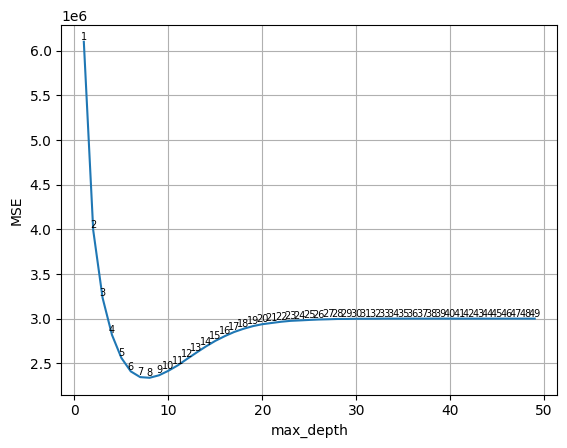

In [ ]:
# Celda 5
#3Creación de la lista de valores para el parámetro max_depht
depth_range =range(1,50,1)

# Definición de lista para almacenar el MSE promedio para cada valor de n_estimators
MSE_scores = []

# Iteraciones
for depth in depth_range:
    clf = RandomForestRegressor(max_depth=depth, random_state=0,n_jobs=-1)
    MSE_scores.append(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())


# Gráfica del desempeño del modelo (MSE) vs la cantidad de max_features
plt.plot(depth_range, MSE_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')
for i, mse in zip(depth_range, MSE_scores):
  plt.text(i, mse, f'{i}', ha='center', fontsize=7, va ='bottom')
plt.grid()
plt.show()


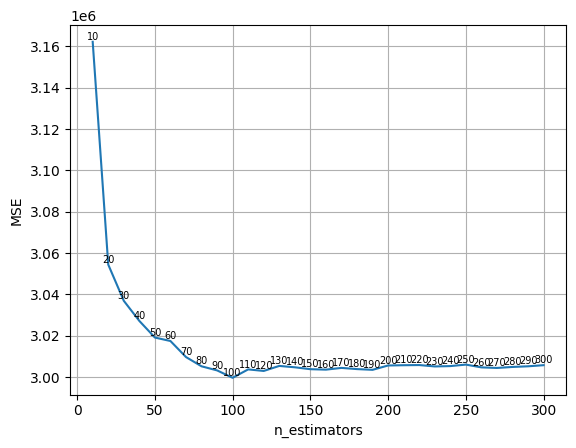

In [ ]:
#3Creación de la lista de valores para el parámetro n_estimators
estimator_range=range(10,310,10)


# Definición de lista para almacenar el MSE promedio para cada valor de n_estimators
MSE_scores = []

# Iteraciones
for estimator in estimator_range:
    clf = RandomForestRegressor(n_estimators = estimator, random_state=0,n_jobs=-1)
    MSE_scores.append(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())


# Gráfica del desempeño del modelo (MSE) vs la cantidad de max_features
plt.plot(estimator_range, MSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('MSE')
for i, mse in zip(estimator_range, MSE_scores):
  plt.text(i, mse, f'{i}', ha='center', fontsize=7, va ='bottom')
plt.grid()
plt.show()


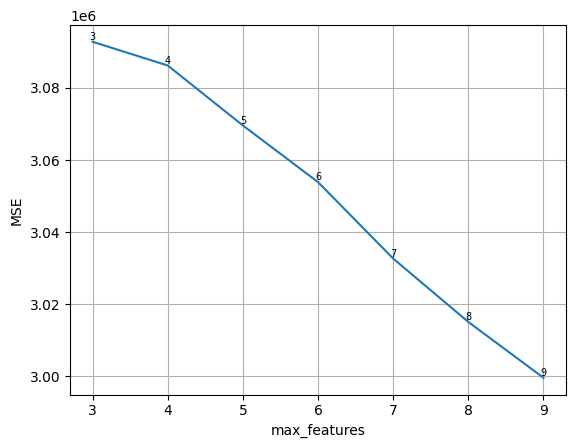

In [ ]:

### Calibración del parámetro max_features

# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(int((len(feature_cols))/3), len(feature_cols)+1)

# Definición de lista para almacenar el MSE promedio para cada valor de max_features
MSE_scores = []

# Iteraciones
for feature in feature_range:
    clf = RandomForestRegressor(max_features=feature, random_state=0,n_jobs=-1)
    MSE_scores.append(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())


# Gráfica del desempeño del modelo (MSE) vs la cantidad de max_features
# Gráfica del desempeño del modelo (MSE) vs la cantidad de max_features
plt.plot(feature_range, MSE_scores)
plt.xlabel('max_features')
plt.ylabel('MSE')
for i, mse in zip(feature_range, MSE_scores):
  plt.text(i, mse, f'{i}', ha='center', fontsize=7, va ='bottom')
plt.grid()
plt.show()


In [ ]:
## Modelo con los parámetros calibrados
#entrenamiento
clfRF_2 = RandomForestRegressor(random_state=0, max_depth=7 ,n_estimators=50, max_features=6,n_jobs=-1)
clfRF_2.fit(X_train, y_train)
#predicciones
y_pred = clfRF_2.predict(X_test)
#métricas de desempeño
mse_RF_2 = mean_squared_error(y_test, y_pred)
rmse_RF_2 = mean_squared_error(y_test, y_pred)**0.5
r2_RF_2 = r2_score(y_test, y_pred)
print(f"Métricas de desempeño random forest calibrado: \nMSE = {mse_RF_2:.2f} \nRMSE = {rmse_RF_2:.2f} \nR2= {r2_RF_2:.2f}")


Métricas de desempeño random forest calibrado: 
MSE = 2440737.32 
RMSE = 1562.29 
R2= 0.84


#### **Análisis desempeño del modelo y parámetros del modelo.**
---
**Parámetros**
1. **max_depth:** este parámetro controla la profundidad máxima de cada árbol en el bosque aleatorio. Este parámetro ayuda a que se ajusten mejor los datos de entrenamiento. Sin embargo, es importante tener cuidado con los valores demasiado altos, ya que puede generar un sobreajuste al modelo. En este caso se escogió el valor de "7" ya que como se observa en el gráfico en este punto se alcanza un MSE mínimo que empieza a aumentar posterioremente y se mantiene estable a partir del valor de "20".
2. **max_features:** controla el número máximo de características o parámetros que se consideran para una mejor división, ene ste caso teniendo en cuenta que es un pronlema de regresión la selección se hizo entre P/3 y P.En este caso se seleccionó el valor de 6, ya que como se observa en el gráfico a partir de este punto la reducción en el MSE es mínima.
3. **n_estimators:** este parámetro controla el número de árboles en el bosque aleatorio. Un valor más alto en este parámetro mejora el rendimiento del modelo, ya que proporciona más árboles para promediar. Sin embargo, es importante tener en cuenta que, después de cierto punto, agregar más árboles puede no mejorar significativamente el desempeño del modelo. Esto se puede observar en la gráfica R2 vs n_estimators, en donde el R2 se estabiliza después de cierto número de estimadores, lo que sugiere que aumentar más árboles no necesariamente mejora el modelo. En este caso, se seleccionó un valor de 50, ya que como se observa en el gráfico a partir de este punto la reducción en el MSE es mínima, y a partir de 100 se estabiliza.

**Desempeño**

1. **Error cuadrático medio (MSE):** el MSE para el modelo de random forest es de 3101046.82, lo que quiere decir que el erro promedio entre el valor predicho y el valor real es de 2440737,32.
2. **Raíz del error cuadrático medio (RMSE):**  el RMSE es de 1562.29, lo que significa que hay una diferencia promedio de 1562.29 entre el precio real y el precio predicho por el modelo.
3. **Coeficiente de determinación (R2):** esta métrica evalúa qué tan bien se ajustan las predicciones a los datos reales. Para este caso, el R2 es de 0.84, lo que significa que aproximadamente el 84% de la variabilidad de los datos se puede explicar por las características incluidas en el modelo.

Se observa que al calibrar los parámetros del modelo de random forest se obtienen mejores resultados que en el modelo sin calibrar, ya que se disminuye el MSE, RMSE y aumenta el R2.


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6

#Definición del modelo
import xgboost as XGB
XGBRegressor = XGB.XGBRegressor()

#Entrenamiento del Modelo y Predicción
XGBRegressor.fit(X_train, y_train)
y_pred = XGBRegressor.predict(X_test)

#Validación del Modelo
mse_XGB = round(mean_squared_error(y_test, y_pred),3)
rmse_XGB = round((mean_squared_error(y_test, y_pred)**0.5),3)
r2_XGB = round(r2_score(y_test, y_pred),3)

print("Métricas de desempeño XGBoost: \nMSE:", str(mse_XGB),"\nRMSE:", str(rmse_XGB),"\nR2:", str(r2_XGB) )

Métricas de desempeño XGBoost: 
MSE: 2576781.075 
RMSE: 1605.236 
R2: 0.832


#### **Análisis desempeño del modelo XGBoost con librería**
---

El modelo muestra un desempeño óptimo al analizar el R2 (0.8), lo que indica una buena capacidad para explicar la variabilidad de los datos.
Adicionalmente, al analizar el RMSE, se observa una diferencia promedio de 1.605 USD (6.200.000 COP aprox) entre el precio real del vehículo y el precio predicho por el modelo, se observa que no hay una diferencia tan amplia entre los valores.

Es importante resaltar que el ejecutar el modelo XGBoost con los parámetros predefinidos, muestra un rendimiento similar al del modelo de Random Forest calibrado.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

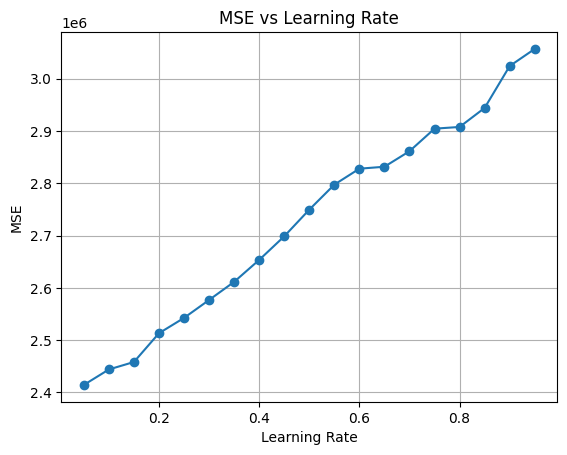

Mejor learning rate: 0.05


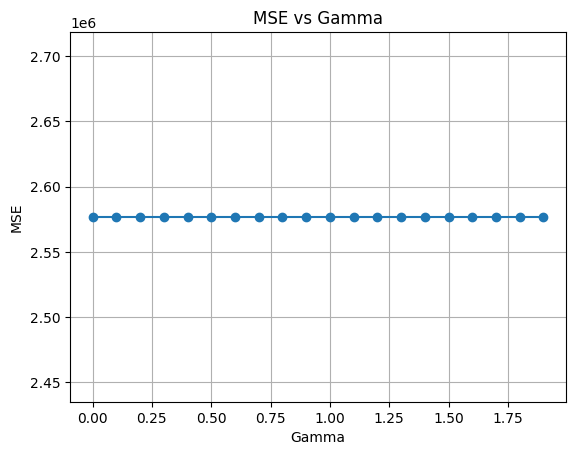

Mejor gamma: 0.0


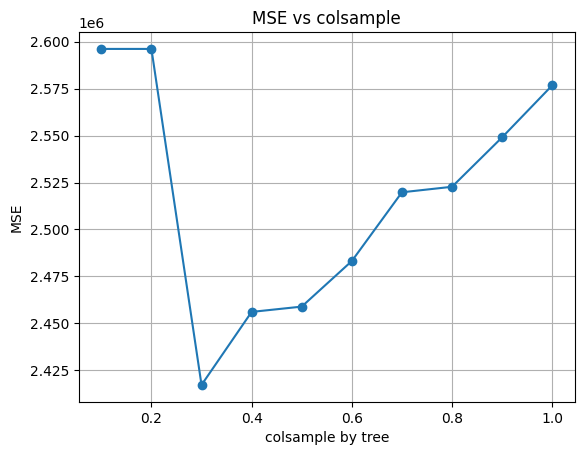

Mejor colsample: 0.3

 Resultados Modelo - Parametros Calibrados Individualmente
 MSE: 2808521.06 
 RMSE: 1675.86 
 R2: 0.82 

Mejores parámetros: {'colsample_bytree': 0.1, 'gamma': 2, 'learning_rate': 1}

Resultados Modelo - Parametros Calibrados en Conjunto
Métricas de desempeño XGBoost calibrado: 
MSE: 2533153.107 
RMSE: 1591.588 
R2: 0.834


In [ ]:
# Celda 7

## CALIBRACION INDIVIDUAL

#Calibración del parametro "learning_rates" y evaluación del modelo -> Tasa de aprendizaje
learning_rates = np.arange(0.05, 1 , 0.05)
MSE_Modelos = []
for valor_learning_rate in learning_rates:
  XGBRegressor = XGB.XGBRegressor(learning_rate = valor_learning_rate)
  XGBRegressor.fit(X_train, y_train)
  y_pred = XGBRegressor.predict(X_test)
  MSE = round(mean_squared_error(y_test, y_pred),2)
  MSE_Modelos.append(MSE)
Mejor_learning_rate = learning_rates[np.argmin(MSE_Modelos)]
plt.plot(learning_rates, MSE_Modelos, marker='o', linestyle='-')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.title('MSE vs Learning Rate')
plt.grid(True)
plt.show()
print('Mejor learning rate:', str(Mejor_learning_rate))

#Calibración del parametro "gamma" y evaluación del modelo  -> Valor mínimo de pérdida que debe reducirse para que se cree un nuevo nodo en el árbol
gammas = np.arange(0, 2 , 0.1)
MSE_Modelos = []
for valor_gamma in gammas:
  XGBRegressor = XGB.XGBRegressor(gamma = valor_gamma)
  XGBRegressor.fit(X_train, y_train)
  y_pred = XGBRegressor.predict(X_test)
  MSE = round(mean_squared_error(y_test, y_pred),2)
  MSE_Modelos.append(MSE)
Mejor_gamma = gammas[np.argmin(MSE_Modelos)]
plt.plot(gammas, MSE_Modelos, marker='o', linestyle='-')
plt.xlabel('Gamma')
plt.ylabel('MSE')
plt.title('MSE vs Gamma')
plt.grid(True)
plt.show()
print('Mejor gamma:', str(Mejor_gamma))

#Calibración del parametro "colsample_bytree" y evaluación del modelo -> Fracción de características a considerar en cada árbol
colsamples = np.arange(0.1, 1.1 , 0.1)
MSE_Modelos = []
for valor_colsample in colsamples:
  XGBRegressor = XGB.XGBRegressor(colsample_bytree = valor_colsample)
  XGBRegressor.fit(X_train, y_train)
  y_pred = XGBRegressor.predict(X_test)
  MSE = round(mean_squared_error(y_test, y_pred),2)
  MSE_Modelos.append(MSE)
Mejor_colsample = round(colsamples[np.argmin(MSE_Modelos)],1)
plt.plot(colsamples, MSE_Modelos, marker='o', linestyle='-')
plt.xlabel('colsample by tree')
plt.ylabel('MSE')
plt.title('MSE vs colsample')
plt.grid(True)
plt.show()
print('Mejor colsample:', str(Mejor_colsample))


### Calibracion del Modelo Final
XGBRegressor = XGB.XGBRegressor(learning_rate = Mejor_learning_rate, gamma = Mejor_gamma, colsample_bytree = Mejor_colsample)
#Entrenamiento del Modelo y Predicción
XGBRegressor.fit(X_train, y_train)
y_pred = XGBRegressor.predict(X_test)
#Validación del Modelo
print("\n Resultados Modelo - Parametros Calibrados Individualmente")
MSE = round(mean_squared_error(y_test, y_pred),2)
RMSE = round((mean_squared_error(y_test, y_pred)**0.5),2)
R2 = round(r2_score(y_test, y_pred),2)
print(" MSE:", str(MSE),"\n", "RMSE:", str(RMSE),"\n", "R2:", str(R2),"\n")

## CALIBRACION CONJUNTA

from sklearn.model_selection import GridSearchCV

Parametros = {'learning_rate': [0.05, 1, 0.05]
             ,'gamma': [0, 2, 0.1]
             ,'colsample_bytree': [0.1, 1.1, 0.1]}
grid_search = GridSearchCV (estimator = XGBRegressor, param_grid = Parametros)
grid_search.fit(X_train, y_train)
Mejores_Parametros = grid_search.best_params_
print("Mejores parámetros:", Mejores_Parametros)

### Calibracion del Modelo Final
XGBRegressor = XGB.XGBRegressor(**Mejores_Parametros)
#Entrenamiento del Modelo y Predicción
XGBRegressor.fit(X_train, y_train)
y_pred = XGBRegressor.predict(X_test)
#Validación del Modelo
print("\nResultados Modelo - Parametros Calibrados en Conjunto")
mse_XGB_2 = round(mean_squared_error(y_test, y_pred),3)
rmse_XGB_2 = round((mean_squared_error(y_test, y_pred)**0.5),3)
r2_XGB_2 = round(r2_score(y_test, y_pred),3)
print("Métricas de desempeño XGBoost calibrado: \nMSE:", str(mse_XGB_2),"\nRMSE:", str(rmse_XGB_2),"\nR2:", str(r2_XGB_2) )

#### **Análisis desempeño del modelo y parámetros del modelo.**
---

Comparando el desempeño del modelo XGBoost no calibrado con el modelo calibrado, se obtiene lo siguiente:
- El R2 es similar, es decir superior a 0.8
- Es importante resaltar que al realizar una calibración conjunta de los parámetros, se obtiene un mejor RMSE, disminuyendo de 1.605 USD a 1.592 USD. Sin embargo, esto no se observa al calibrar los parámetros individualmente, ya que en este caso se obtiene un RMSE superior de 1.605 USD.

Al analizar las gráficas correspondientes a la calibración individual:

- Se evidencia que un aumento en el valor de learning rate, aumenta el MSE del modelo perjudicando su capacidad predictiva.
- Al variar el parámetro gamma, se observa que el MSE permanece constante, se concluye en este caso que no hay diferencia significativa entre los diferentes valores.
- Al aumentar el valor de colsample, se evidencia que un incremento en su valor podria mejora inicialmente el desempeño del modelo, sin embargo, no hay una relación lineal, pues hay un punto óptimo donde el MSE se minimiza y despues de este punto el MSE aumenta y por lo tanto afecta el desempeño del modelo.

Para concluir, es importante realizar la calibración de los parametros, pues el desempeño del modelo mejora, sin embargo se deben calibrar conjuntamente.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
#funciones genéricas para comparar gráficamente
#función de etiquetas
def add_labels(plots):
    for bar in plots.patches:
      plots.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
#función de graficar
def graficar(x, y, medida_desempeño):
    df = pd.DataFrame({'Modelo': x, medida_desempeño: y})

    plt.figure(figsize=(10, 6))
    plots = sns.barplot(x='Modelo', y= medida_desempeño, data=df, palette="viridis")
    add_labels(plots)
    plt.title(f'Comparación del {medida_desempeño}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

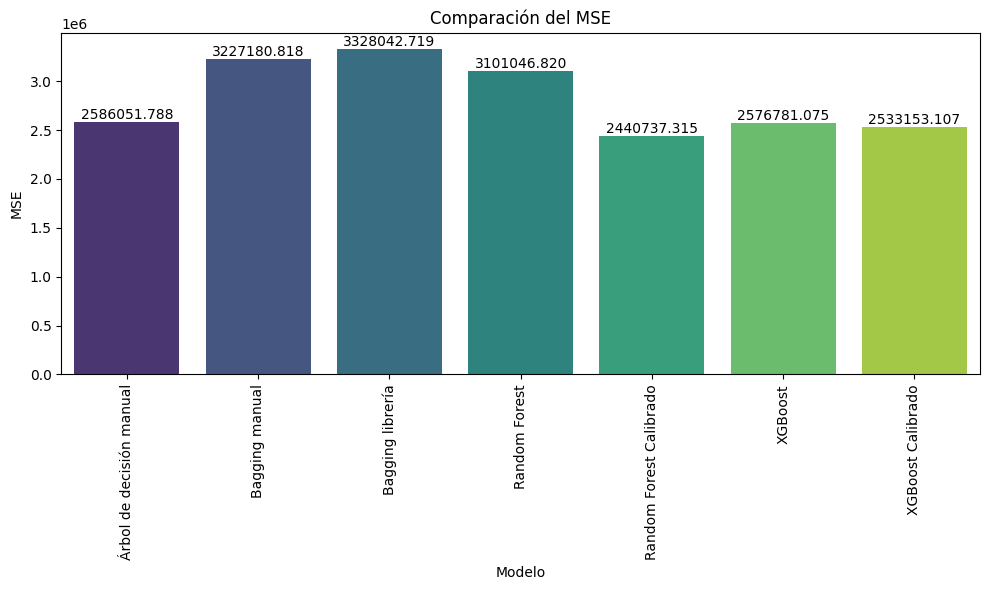

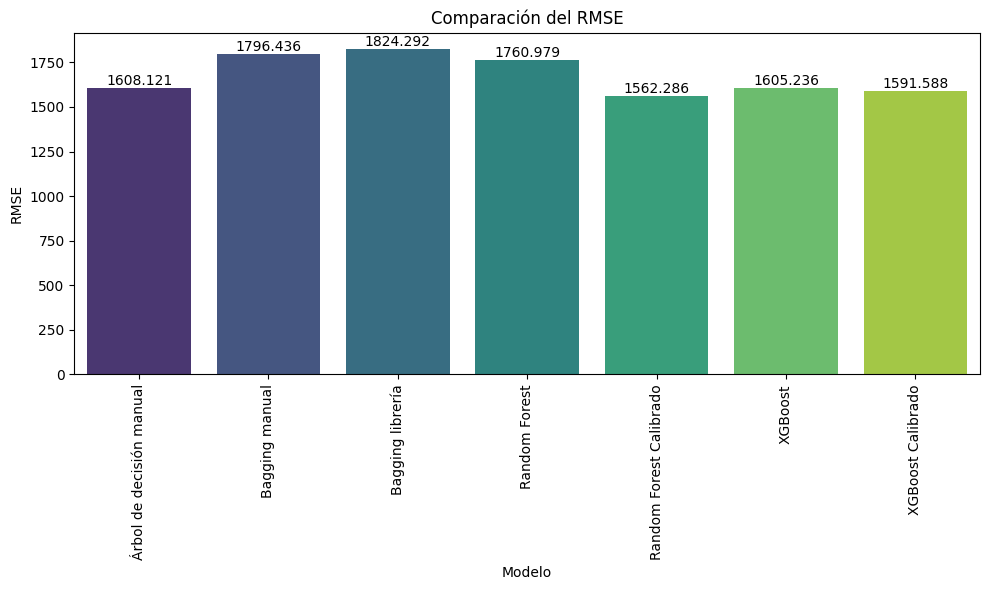

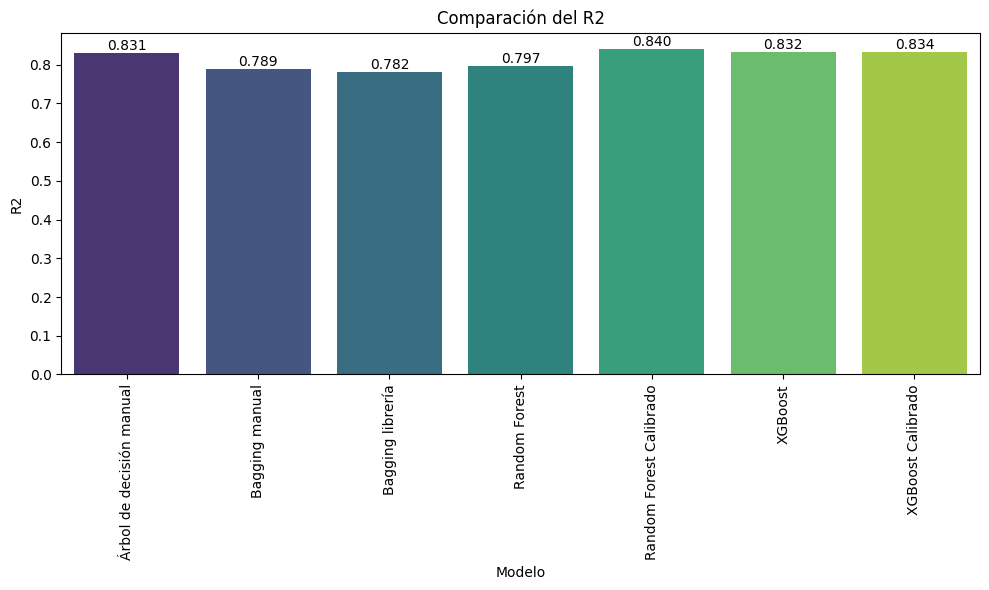

In [ ]:
# MSE

ejeX = ['Árbol de decisión manual','Bagging manual','Bagging librería', 'Random Forest', 'Random Forest Calibrado', 'XGBoost', 'XGBoost Calibrado']
ejeY = [MSE_Modelo_manual, mse_bagm, mse_bag, mse_RF_1, mse_RF_2, mse_XGB, mse_XGB_2]
graficar(ejeX, ejeY, 'MSE')

# RMSE
ejeY = [RMSE_Modelo_manual, rmse_bagm, rmse_bag, rmse_RF_1, rmse_RF_2, rmse_XGB, rmse_XGB_2]
graficar(ejeX, ejeY, 'RMSE')

# R2
ejeY = [R2_Modelo_manual, r2_bagm, r2_bag, r2_RF_1, r2_RF_2, r2_XGB, r2_XGB_2]
graficar(ejeX, ejeY, 'R2')

#### **Análisis de Resultados**
---
**Comparación de modelos**

Comparando los resultados de los modelos, se puede observar lo siguiente:

|Modelo|MSE|RMSE|R2|  
|-|-|-|-|  
|Árbol de decisión manual|2586051.788|1608.121|0.831|  
|Bagging manual|3227180.818|1796.436|0.789|
|Bagging |3328042.719|1824.292|0.782|
|Random Forest|3101046.82|1760.979|0.797|
|Random Forest Calibrado|2440737.32|1562.286|0.840|
|XGBoost|2576781.075|1605.236|0.832|
|XGBoost Calibrado|2533153.107|1591.588|0.834|
  
<br>

El modelo que sobresale con las mejores métricas de desempeño es el *Random Forest calibrado*. Esto se evidencia con un R2 ligeramente superior, junto con un MSE y RMSE más bajos en comparación con los otros modelos evaluados. Estas métricas sugieren que el modelo calibrado se adapta de manera más precisa a los datos analizados y tiene una mejor capacidad para explicar la variabilidad en los datos.

En contraste, el modelo de *Bagging con librería* muestra el peor desempeño entre todos los modelos analizados. Se caracteriza por un R2 inferior y un MSE y RMSE superiores en comparación con los demás modelos.

Cuando se compara específicamente entre los modelos de Random Forest y XGBoost calibrados y sin calibrar, el *Random Forest sin calibrar* muestra un desempeño inferior en relación con el XGBoost sin calibrar y los modelos calibrados.

Teniendo en cuenta lo anterior, se concluye que el proceso de calibración es de suma importancia, ya que permite ajustar los parámetros del modelo para optimizar su rendimiento. Esto se evidencia claramente en el caso del Random Forest calibrado, que sobresale con las mejores métricas de desempeño en comparación con los otros modelos evaluados.

Sin embargo, no sucede lo mismo con el modelo XGBoost calibrado. lo cual se puede deber a los parámetros específicos utilizados en su calibración. Esto sugiere que, si bien la calibración es esencial, también lo es la selección cuidadosa de los parámetros para garantizar el máximo rendimiento del modelo.

**Ventajas del mejor modelo**

Las ventajas del modelo Random Forest calibrado son:
1. Tiene una mayor capacidad predictiva en comparación con los otros modelos.
2. La calibración de parámetros ayuda a optimizar el modelo, lo que reduce la tendencia al sobreajuste de los datos.
3. Este modelo permite conocer la importancia de cada una de las variables predictoras en la predicción de la variable de interés.
4. Es un modelo robusto que no se ve afectado por la presencia de outliers o datos atípicos.


**Desventajas del modelo con menor desempeño**

Las desventajas del Bagging con librería son:
1. Tiene limitaciones en su interpretación.
2. El rendimiento del modelo puede depender en gran medida del rendimiento del modelo base utilizado, para este caso se utilizó el DecisionTreeRegressor, calibrando el parámetro n_features.
3. Puede requerir un mayor esfuerzo computacional

Las deventajas del Random Forest sin calibrar son:

1. Sin la calibración adecuada, este modelo puede ajustarse demasiado a los datos de entrenamiento, genrando un posible sobreajuste de los datos.
2. El modelo toma los parámetros por defecto, lo que puede llevar a un rendimiento negativo en los conjuntos de datos.
3. Al no tener los parámetros definidos, puede generar análisis más complejos, lo cual puede llevar a un mayor gasto computacional.